# Analysis of generalizability and $n^*$

This notebook analyzes the results of `demo1_estimate_nstar.ipynb` to investigate the dependency between the desired generalizability $\alpha^*$, the similarity threshold for rankings $\delta^*$, and the number of experimental conditions that guarantee generalizable results $n^*$. 

## Imports and configuration

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import yaml

from pathlib import Path
from tqdm.auto import tqdm

Next, we load the parameters from the configuration file. 

In [2]:
with open("config.yaml", 'r') as file:
    config = yaml.safe_load(file)

OUTPUT_DIR = Path(config['paths']['output_dir'])
FIGURES_DIR = Path(config['paths']['figures_dir'])
FIGURES_DIR.mkdir(exist_ok=True, parents=True)

DATASET = Path(config['data']['dataset_path'])
EXPERIMENTAL_FACTORS = config['data']['experimental_factors']
TARGET = config['data']['target']
ALTERNATIVES = config['data']['alternatives']

## Loading 

We concatenate all of the output dataframes and add a column with the number of datasets we have results on, conditioned on (model, tuning, scoring). In the terminology of the paper, we fix the held-constant and design factors and count the number of levels of the allowed-to-vary factor. 

In [3]:
df_nstar = pd.concat([pd.read_parquet(x) 
                      for x in tqdm(list(OUTPUT_DIR.glob("**/**/**/nstar.parquet")), 
                                    desc="Loading dataframes")]).reset_index(drop=True)

fixed_factors = [factor for factor, lvl in EXPERIMENTAL_FACTORS.items() if lvl == "_all"]  
df_nstar = df_nstar.join(df_nstar.groupby(fixed_factors)["N"].max(), on=fixed_factors, rsuffix="max")

Loading dataframes:   0%|          | 0/60 [00:00<?, ?it/s]

## Plot parameters

In [4]:
sns.set(style="ticks", context="paper", font="times new roman")

# mpl.use("TkAgg")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r"""
    \usepackage{mathptmx}
    \usepackage{amsmath}
"""
mpl.rc('font', family='Times New Roman')

# pretty names
pc = {"alpha": r"$\alpha^*$", "eps": r"$\varepsilon^*$", "nstar": r"$n^*$", "delta": r"$\delta^*$", "N": r"$N$", "nstar_absrel_error": "relative error", "aq": r"$\varepsilon^{\alpha^*}_n$", "n": r"$n$"}  # columns
pk = {"borda_kernel_alternative_OHE": r"$\kappa_b^{\text{OHE}, 1/n}$", "mallows_kernel_nu_auto": r"$\kappa_m^{1/\binom{n}{2}}$", "jaccard_kernel_k_1": r"$\kappa_j^{1}$"}  # kernels
pk.update({"borda_kernel_alternative_OHE": "$g_1$", "mallows_kernel_nu_auto": "$g_3$", "jaccard_kernel_k_1": "$g_2$"})  # rename to goal_1, 2, 3

The following function outputs a very conservative upper bound for $n^*$.

In [5]:
@np.vectorize
def theoretical_nstar(alphastar, epsstar, kbar=1):
    beta1 = -2
    beta0 = 2*np.log(np.sqrt(2*kbar) + np.sqrt(-4*kbar * np.log(1-alphastar)))
    return np.exp(beta0 + beta1*np.log(epsstar))

## How $n^*$ depends on $\alpha^*$ and $\delta^*$

We can finally visualize how $n^*$ depends on $\alpha^*$ and $\delta^*$. 
To do so, we first fix $a\alpha^* = 0.05$ and then $\delta^* = 0.05$ (corresponding to $\varepsilon(\delta^*) \approx 0.31$).

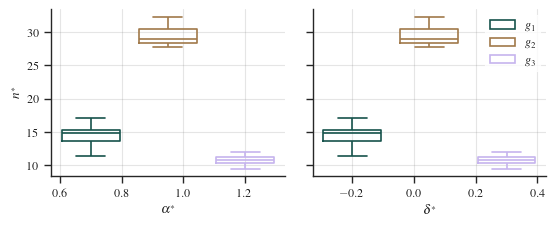

In [6]:
alpha_fixed = 0.95
delta_fixed = 0.05
eps_fixed = 0.31


plt.close("all")
fig, axes = plt.subplots(1, 2, figsize=(5.5, 5.5/2.5), width_ratios=(1, 1), sharey=True)

# ----  ALPHA
ax = axes[0]
dfplot = df_nstar.loc[(df_nstar["delta"] == delta_fixed) & (df_nstar["N"] == df_nstar["Nmax"])]

# Make dfplot pretty
dfplot = dfplot.rename(columns=pc)
dfplot["kernel"] = dfplot["kernel"].map(pk)
dfplot["nstar_th"] = theoretical_nstar(dfplot[pc["alpha"]], dfplot[pc["eps"]], kbar=1)

# Plot
sns.boxplot(dfplot, x=pc["alpha"], y=pc["nstar"], ax=ax, hue="kernel", showfliers=False, palette="cubehelix",
            dodge=True, native_scale=True, fill=False, legend=False,
            width=0.75, boxprops={"linewidth": 1.2}, gap=0.25)
# ax.set(xticks=[0.7, 0.8, 0.9, 0.99])
ax.grid(color="grey", alpha=0.2)

# Uncomment to plot the conservative estimate for nstar
# alphas = np.linspace(dfplot[pc["alpha"]].min(), dfplot[pc["alpha"]].max(), 100)
# nstars_th = theoretical_nstar(alphas, eps_fixed)
# sns.lineplot(x=alphas, y=nstars_th, ax=ax, c="black", linewidth=0.5)  

# ----  DELTA
ax = axes[1]
dfplot = df_nstar.loc[(df_nstar["alpha"] == alpha_fixed) & (df_nstar["N"] == df_nstar["Nmax"])]

# Make dfplot pretty
dfplot = dfplot.rename(columns=pc)
dfplot["kernel"] = dfplot["kernel"].map(pk)

# plot
sns.boxplot(dfplot, x=pc["delta"], y=pc["nstar"], ax=ax, hue="kernel", showfliers=False, palette="cubehelix",
            dodge=True, native_scale=True, fill=False, legend=True,
            width=0.75, boxprops={"linewidth": 1.2}, gap=0.25)
# ax.set(xticks=[0.01, 0.1, 0.2, 0.3])
ax.grid(color="grey", alpha=0.2)

# Uncomment to plot the conservative estimate for nstar
# epss = np.linspace(dfplot[pc["eps"]].min(), dfplot[pc["eps"]].max(), 100)
# nstars_th = theoretical_nstar(alpha_fixed, epss)
# # sns.lineplot(x=epss, y=nstars_th, ax=ax, c="black", linewidth=0.5) 

ax.legend(*ax.get_legend_handles_labels()).get_frame().set_edgecolor("w")

sns.despine(right=True, top=True)
plt.tight_layout(pad=.5)
plt.subplots_adjust(wspace=.12)
plt.savefig(FIGURES_DIR / "encoders_nstar_alpha_delta.pdf")
# plt.savefig(FIGURES_DIR / "encoders_nstar_alpha_delta_upperbound.pdf")
plt.show()

### Most and least generalizable combinations of design factors

In [7]:
kernel = "jaccard_kernel_k_1"

df_ = df_nstar.query("kernel==@kernel and alpha==@alpha_fixed and delta==@delta_fixed")
df_ = df_.loc[df_["N"] == df_["Nmax"]]
df_.loc[(df_["nstar"] == df_["nstar"].min()) | (df_["nstar"] == df_["nstar"].max())]

,kernel,alpha,eps,delta,disjoint,replace,N,nstar,nstar_lower,nstar_upper,variance,var_lower_bound,singular,tuning,model,scoring,Nmax
150,jaccard_kernel_k_1,0.95,0.316228,0.05,True,False,50,27.659671,27.514999,27.974174,0.949434,0.845671,False,no,LGBMC,BACC,50
195,jaccard_kernel_k_1,0.95,0.316228,0.05,True,False,50,32.240058,31.943006,32.454114,0.915278,0.853238,False,no,LR,AUC,50


## How $n^*$ depends on $N$

We estimate the $(\alpha^*, \delta^*)$-generalizability on a sample of $N$ results.
This section shows how the estimate of $n^*$ changes with bigger samples.
In particular, we want to know how large $N$ should be to get an estimate for $n^*$ which is "close enough" to the estimate we get at $N=50$.

In [8]:
pc.update({"nstar_rel_error": "$(n^*_N-n^*) / n^*$"})

nstar_50 = df_nstar.loc[df_nstar["N"] == df_nstar["Nmax"]].drop(columns=["N", "Nmax"])
keys = ["kernel", "alpha", "eps", "model", "tuning", "scoring"]
df_ = pd.merge(df_nstar, nstar_50, left_on=keys, right_on=keys, suffixes=("", "_true"))[keys + ["nstar", "nstar_true", "N", "Nmax"]]
df_["nstar_error"] = df_["nstar"] - df_["nstar_true"]
df_["nstar_relative_error"] = (df_["nstar"] - df_["nstar_true"]) / df_["nstar_true"]
df_["nstar_absolute_error"] = np.abs(df_["nstar"] - df_["nstar_true"])
df_["nstar_absrel_error"] = np.abs(df_["nstar"] - df_["nstar_true"]) / df_["nstar_true"]
df_["nstar_rel_error"] = (df_["nstar"] - df_["nstar_true"]) / df_["nstar_true"]

# df_ = df_.loc[df_["N"] != df_["Nmax"]]
df_ = df_.query("Nmax == 50")

dfplot = df_.copy().query("N < Nmax").rename(columns=pc)
dfplot["kernel"] = dfplot["kernel"].map(pk)

y = pc["nstar_rel_error"]

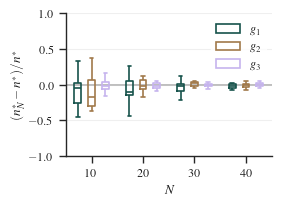

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5.5/2, 2))

sns.boxplot(dfplot, x=pc["N"], y=y, showfliers=False, fliersize=0.3, hue="kernel", palette="cubehelix", ax=ax, legend=True, linewidth=1.2, fill=False, gap=0.5)  

ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.axhline(0, color="black", zorder=-1, alpha=0.3)
ax.grid(axis="y", zorder=-1, alpha=0.3)

ax.legend(*ax.get_legend_handles_labels()).get_frame().set_edgecolor("w")
sns.despine()
plt.tight_layout(pad=.5)

plt.savefig(FIGURES_DIR / f"encoders_nstar_rel_error.pdf")
plt.show()

## True $n^*$ estimate error

We estimate the $(\alpha^*, \delta^*)$-generalizability on a sample of $N$ results.
This section shows how the estimate of $n^*$ changes with bigger samples.
In particular, we want to know how large $N$ should be to get an estimate for $n^*$ which is "close enough" to the estimate we get at $N=50$.

In [10]:
nstar_50 = df_nstar.loc[df_nstar["N"] == df_nstar["Nmax"]].drop(columns=["N", "Nmax"])
keys = ["kernel", "alpha", "eps", "model", "tuning", "scoring"]
df_ = pd.merge(df_nstar, nstar_50, left_on=keys, right_on=keys, suffixes=("", "_true"))[keys + ["nstar", "nstar_true", "N", "Nmax"]]
df_["nstar_error"] = df_["nstar"] - df_["nstar_true"]
df_["nstar_relative_error"] = (df_["nstar"] - df_["nstar_true"]) / df_["nstar_true"]
df_["nstar_absolute_error"] = np.abs(df_["nstar"] - df_["nstar_true"])
df_["nstar_absrel_error"] = np.abs(df_["nstar"] - df_["nstar_true"]) / df_["nstar_true"]
# df_ = df_.loc[df_["N"] != df_["Nmax"]]
df_ = df_.query("Nmax == 50")

dfplot = df_.copy().query("N < Nmax").rename(columns=pc)
dfplot["kernel"] = dfplot["kernel"].map(pk)

y = pc["nstar_absrel_error"]

In [11]:
df_nstar = pd.concat([pd.read_parquet(x) 
                      for x in tqdm(list(OUTPUT_DIR.glob("**/**/**/nstar.parquet")), 
                                    desc="Loading dataframes")]).reset_index(drop=True)

fixed_factors = [factor for factor, lvl in EXPERIMENTAL_FACTORS.items() if lvl == "_all"]  
df_nstar = df_nstar.join(df_nstar.groupby(fixed_factors)["N"].max(), on=fixed_factors, rsuffix="max")

Loading dataframes:   0%|          | 0/60 [00:00<?, ?it/s]

## Illustrative Example: Algorithm to predict $n^*$

The following cell provides a representation of the algorithm to estimate $n^*$. 
First of all, we show it for the combination `model=DTC` (Decision Tree), `tuning=no` (No tuning), `scoring=AUC` (Area Under the ROC).

First, we fix $\alpha^*$, $\delta^*$ and the kernel (Mallows kernel in this case).
Second, take the distribution of the MMD (for varying sample sizes $n$) and compute the $\alpha^*$-quantile.   

In [12]:
model = "DTC"
tuning = "no"
scoring = "ACC"

kernelname = "jaccard_kernel_k_1"
alpha = 0.95
delta = 0.01
eps = np.sqrt(2 * (1 - (1-delta)))
Ns = [10, 20, 50]

OUTPUT_MMD_DIR = OUTPUT_DIR / f"tuning={tuning}_model={model}_scoring={scoring}" / kernelname
pc.update({"generalizability": r"$n$-Gen"})

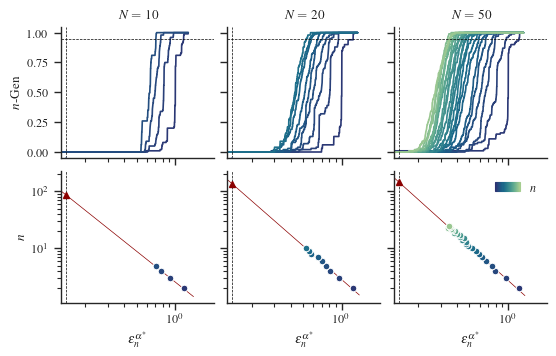

In [13]:
from sklearn.linear_model import LinearRegression
from warnings import filterwarnings
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Patch


filterwarnings("ignore")

plt.close("all")

palette="crest_r"
colors = sns.color_palette(palette, n_colors=24)
lw = 0.5


fig, axes = plt.subplots(2, 3, figsize=(5.5, 3.5), sharex=True, sharey="row")

for N, axcol in zip(Ns, axes.T):
    
    # -- Load dataframes
    dfq = pd.read_parquet(OUTPUT_MMD_DIR / "computed_quantiles" / f"dfmmd_{N}.parquet")  # contains the distribution of the n-MMD 
    dfy = pd.read_parquet(OUTPUT_MMD_DIR / "computed_generalizability" / f"dfy_{N}.parquet")
    dfy["eps"] = np.exp(dfy["log(eps)"])
    alpha_quantiles = {n: np.quantile(np.quantile(dfq.query("n == @n")["eps"], alpha, method="linear"), alpha) for n in dfq["n"].unique()}
    dfaq = pd.DataFrame(alpha_quantiles, index=[0]).melt(var_name="n", value_name="aq").rename(columns=pc)
    
    # -- Generalizability
    ax = axcol[0]
    ax.set_xscale("log")
    sns.lineplot(dfy.rename(columns=pc), x=pc["eps"], y=pc["generalizability"], hue=pc["n"], palette=colors, ax=ax, legend=False)
    
    ax.set_title(f"$N={N}$")
    
    
    # Quantile lines
    # for (n, laq), color in zip(alpha_quantiles.items(), sns.color_palette(palette, n_colors=len(alpha_quantiles))):
    #     ax.vlines(laq, ymin=0, ymax=alpha, ls="-", color=color, lw=lw)
        # ax.axvline(laq, ymin=-1.2, ymax=0, ls=":", color=color, lw=lw, zorder=-1, clip_on=False)
    ax.axhline(alpha, color="black", ls="--", lw=lw)
    ax.axvline(eps, color="black", ls="--", lw=lw)
    ax.axvline(eps, ymin=-1, ymax=0)
    
    # -- Quantiles for regression
    ax = axcol[1]
    ax.set_xscale("log")
    ax.set_yscale("log")
    sns.lineplot(dfaq, x=pc["aq"], y=pc["n"], ax=ax, ls="", marker="o", hue=pc["n"], legend=False, palette=colors)
    
    # Linear regression
    X = np.log(dfaq[pc["aq"]]).to_numpy().reshape(-1, 1)
    y = np.log(dfaq[pc["n"]]).to_numpy().reshape(-1, 1)
    
    padding = 1.1
    epss = np.linspace(eps / padding, np.max(dfq["eps"]) * padding, 1000)
    lr = LinearRegression().fit(X, y)
    ns_pred = np.exp(lr.predict(np.log(epss).reshape(-1, 1)).reshape(1, -1)[0])
    nstar = int(ns_pred[np.argmin(np.abs(epss - eps))])
    ax.plot(epss, ns_pred, color="darkred", lw=lw, zorder=0)
    
    ax.set_xlim(eps/padding)
    
    # Quantile lines
    # for (n, aq), color in zip(alpha_quantiles.items(), sns.color_palette(palette, n_colors=len(alpha_quantiles))):
    #     ax.vlines(aq, ymin=n, ymax=nstar, ls="-", color=color, lw=lw)
        # ax.axvline(aq, ymin=1, ymax=1.2, ls=":", color=color, lw=lw, zorder=-1, clip_on=False)
    ax.axvline(eps, color="black", ls="--", lw=lw)
    ax.plot([eps], [nstar], color="darkred", marker="^", markersize=5, ls="", lw="0.5")

    # -- Legend   
    if N == 50:
        cmap_gradient = [Patch(facecolor=c, edgecolor=c, label=palette) for c in sns.color_palette(palette, n_colors=24, as_cmap=True)(np.linspace(0, 1, 24))]
        ax.legend(handles=[cmap_gradient], labels=["$n$"], handler_map={list: HandlerTuple(ndivide=None, pad=0)}).get_frame().set_edgecolor("w")


# - General formatting
sns.despine(top=True, right=True)
plt.tight_layout(pad=0.5)


plt.savefig(FIGURES_DIR / f"nstar_estimation.pdf")
plt.show()

In [22]:
# Histogram of the MMD

dfy = pd.concat([pd.read_parquet(x) 
                      for x in tqdm(list(OUTPUT_DIR.glob("**/mallows_kernel_nu_auto/**/dfmmd_*.parquet")), 
                                    desc="Loading dataframes")]).reset_index(drop=True)


Loading dataframes:   0%|          | 0/93 [00:00<?, ?it/s]

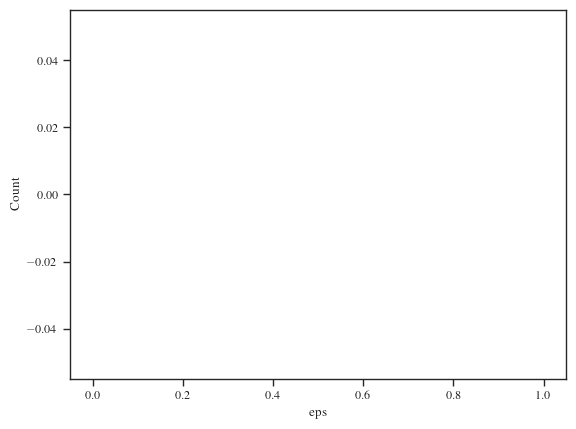

In [30]:
dfmmd = dfy.query("n == 20")

sns.histplot(dfmmd, x="eps")
plt.show()